In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# 設定參數

In [ ]:
# Read the dataset
df = pd.read_csv(r"C:\Users\user\OneDrive\桌面\研究所\課程內容\遞迴神經網路與變形器\HW1\AI_Human.csv\AI_Human.csv")

In [ ]:
# 計算MAX_VOCAB_SIZE

# Tokenize
all_words = [word for text in df['text'] for word in text.split()]
word_counts = Counter(all_words)

# 計算累積詞頻
sorted_counts = sorted(word_counts.values(), reverse=True)
print(sorted_counts[:10])  # 顯示前10個詞頻
cumulative_freq = [sum(sorted_counts[:i]) / sum(sorted_counts) for i in range(1, len(sorted_counts))]
print(cumulative_freq[:10])  # 顯示前10個累積詞頻

# # 繪製累積詞頻圖
# plt.plot(cumulative_freq)
# plt.xlabel("Vocabulary Size")
# plt.ylabel("Cumulative Frequency")
# plt.title("Vocabulary Coverage")
# plt.show()

# 找出覆蓋 95% 的詞彙量
for i, freq in enumerate(cumulative_freq):
    if freq >= 0.95:
        print(f"95% 的文本內容被前 {11394} 個詞覆蓋")
        break

# 95% 的文本內容被前 11394 個詞覆蓋
# 共有 544,828 個不同的詞

[7861803, 6446363, 4913122, 4425797, 3934465, 2828167, 2690593, 2669857, 1820787, 1797581]
[0.04104732101982395, 0.07470447720541082, 0.10035641683599676, 0.1234639801045719, 0.14400624603215387, 0.15877241083514784, 0.1728202869527116, 0.18675989817879093, 0.19626642339924255, 0.20565178759192662]
95% 的文本內容被前 11394 個詞覆蓋


In [21]:
print(len(word_counts))

544828


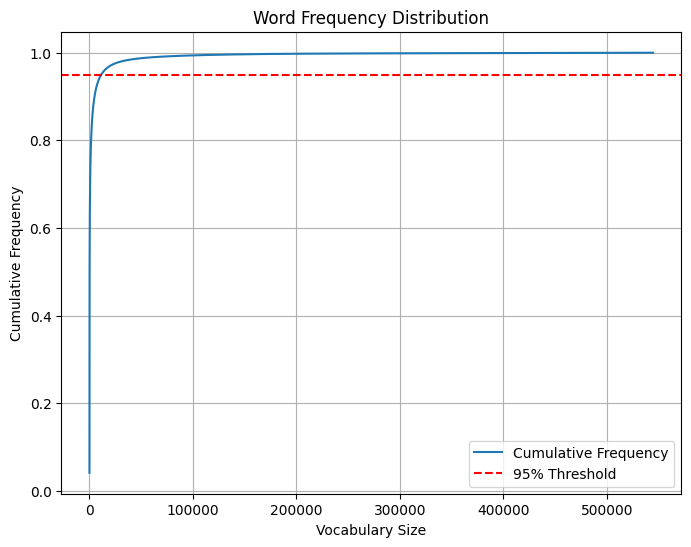

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_freq)), cumulative_freq, label="Cumulative Frequency")
plt.axhline(y=0.95, color='r', linestyle='dashed', label="95% Threshold")
plt.xlabel("Vocabulary Size")
plt.ylabel("Cumulative Frequency")
plt.title("Word Frequency Distribution")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 計算MAX_SEQ_LENGTH

# 計算每個文本的長度
text_lengths = [len(text.split()) for text in df['text']]

# 找出文本長度的分佈
percentiles = np.percentile(text_lengths, [50, 75, 80, 85, 90, 95, 99, 100])
print("文本長度的分佈:")
for p, length in zip([50, 75, 80, 85, 90, 95, 99, 100], percentiles):
    print(f"{p}% 的文本長度小於: {length}")



# 文本長度的分佈:
# 50% 的文本長度小於: 363.0
# 75% 的文本長度小於: 471.0
# 80% 的文本長度小於: 505.0
# 85% 的文本長度小於: 552.0
# 90% 的文本長度小於: 615.0
# 95% 的文本長度小於: 721.0
# 99% 的文本長度小於: 956.0
# 100% 的文本長度小於: 1668.0

文本長度的分佈:
50% 的文本長度小於: 363.0
75% 的文本長度小於: 471.0
80% 的文本長度小於: 505.0
85% 的文本長度小於: 552.0
90% 的文本長度小於: 615.0
95% 的文本長度小於: 721.0
99% 的文本長度小於: 956.0
100% 的文本長度小於: 1668.0


In [47]:
MAX_VOCAB_SIZE = 15000  # 詞彙表大小 可設12000-15000
MAX_SEQ_LENGTH = 600 # 最大序列長度
EMBEDDING_DIM = 100  # Word2Vec 向量維度
BATCH_SIZE = 32
LSTM_UNITS = 256
NUM_EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer & Embedding


In [ ]:
# def tokenizer(text):
#     return text.split()

# # Build vocabulary
# counter = Counter()
# for text in df['text']:
#     counter.update(tokenizer(text))
# vocab = {word: i+2 for i, (word, _) in enumerate(counter.items())}
# vocab['<unk>'] = 0
# vocab['<pad>'] = 1

# # Text numerization
# def numericalize(text, vocab):
#     return [vocab.get(word, vocab['<unk>']) for word in tokenizer(text)]

# def pad_collate_fn(batch, pad_idx):
#     texts, labels = zip(*batch)
#     text_lens = [len(text) for text in texts]
#     max_len = max(text_lens)
#     padded_texts = torch.full((len(texts), max_len), pad_idx, dtype=torch.long)
#     for i, text in enumerate(texts):
#         padded_texts[i, :text_lens[i]] = text
#     return padded_texts, torch.tensor(labels, dtype=torch.float)


In [36]:
# 使用 TensorFlow Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(df['text'])

# 文本數值化並填充序列
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

# 訓練 Word2Vec

In [37]:
word2vec_model = Word2Vec(sentences=[text.split() for text in df['text']], vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

# 建立詞嵌入矩陣
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE and word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# 建立 PyTorch Dataset

In [ ]:
# class TextDataset(Dataset):
#     def __init__(self, texts, labels, vocab):
#         self.texts = texts
#         self.labels = labels
#         self.vocab = vocab

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = numericalize(self.texts[idx], self.vocab)
#         label = self.labels[idx]
#         return torch.tensor(text), torch.tensor(label, dtype=torch.float)

# # Split datasets
# texts_train, texts_test, labels_train, labels_test = train_test_split(
#     df['text'], df['generated'], test_size=0.2, random_state=42)

# # Creat datasets
# train_dataset = TextDataset(texts_train.tolist(), labels_train.tolist(), vocab)
# test_dataset = TextDataset(texts_test.tolist(), labels_test.tolist(), vocab)

# # Build data loader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: pad_collate_fn(x, vocab['<pad>']))
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: pad_collate_fn(x, vocab['<pad>']))



In [38]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    

# 轉換標籤
labels = np.array(df['generated'], dtype=np.float32)  # 0: Human, 1: AI

# 切分數據集 (7:2:1)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)  # 0.3 再拆成 0.2 和 0.1


# 創建 DataLoader
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# 定義 LSTM + Attention 模型

In [39]:
# class LSTMClassifier(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<pad>'])
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, text):
#         embedded = self.embedding(text)
#         _, (hidden, _) = self.lstm(embedded)
#         return self.fc(hidden.squeeze(0))

In [40]:
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(AttentionLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim * 2)  # 雙向 LSTM
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        
        # Attention 機制
        attention_scores = torch.tanh(self.attention(lstm_out))  # [batch_size, seq_len, hidden_dim * 2]
        attention_weights = torch.softmax(attention_scores, dim=1)  # [batch_size, seq_len, hidden_dim * 2]
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # [batch_size, hidden_dim * 2]

        output = self.fc(self.dropout(context_vector))
        return torch.sigmoid(output)

# 訓練

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = LSTMClassifier(len(vocab), embedding_dim=100, hidden_dim=256, output_dim=1).to(device)
# criterion = nn.BCEWithLogitsLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# def train(model, iterator, optimizer, criterion):
#     model.train()
#     epoch_loss = 0
#     for texts, labels in iterator:
#         texts, labels = texts.to(device), labels.to(device)
#         optimizer.zero_grad()
#         predictions = model(texts).squeeze(1)
#         loss = criterion(predictions, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     return epoch_loss / len(iterator)

# for epoch in range(5):
#     train_loss = train(model, train_loader, optimizer, criterion)
#     print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')

In [41]:
# 初始化模型
model = AttentionLSTM(vocab_size=MAX_VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=LSTM_UNITS, output_dim=1, embedding_matrix=embedding_matrix)
model = model.to(DEVICE)
# 定義損失函數和優化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # 記錄 loss
    train_losses = []
    val_losses = []
    # 記錄準確率
    train_accuracies = []
    val_accuracies = []


    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0, 0

        # ===== 訓練階段 =====
        for texts, labels in train_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(texts).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += ((outputs > 0.5) == labels).sum().item()
        
        train_acc /= len(train_loader.dataset)
        train_accuracies.append(train_acc)
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ===== 驗證階段 =====
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(DEVICE), labels.to(DEVICE)
                outputs = model(texts).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += ((outputs > 0.5) == labels).sum().item()

        val_acc /= len(val_loader.dataset)
        val_accuracies.append(val_acc)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [48]:
# 訓練模型
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)


Epoch 1/5: Train Loss: 0.0014, Train Acc: 0.9996, Val Loss: 0.0021, Val Acc: 0.9994
Epoch 2/5: Train Loss: 0.0011, Train Acc: 0.9996, Val Loss: 0.0019, Val Acc: 0.9994
Epoch 3/5: Train Loss: 0.0009, Train Acc: 0.9997, Val Loss: 0.0016, Val Acc: 0.9995
Epoch 4/5: Train Loss: 0.0008, Train Acc: 0.9998, Val Loss: 0.0019, Val Acc: 0.9995
Epoch 5/5: Train Loss: 0.0006, Train Acc: 0.9998, Val Loss: 0.0020, Val Acc: 0.9995


# 繪製 Loss、Accuracy 曲線

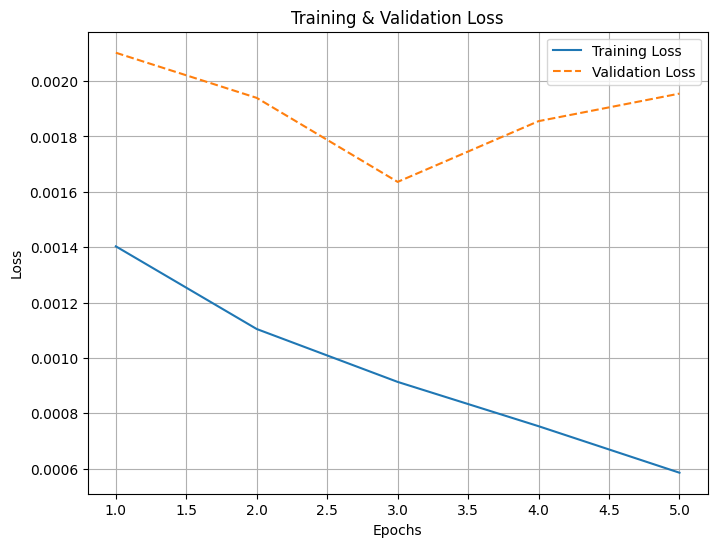

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label="Training Loss")
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

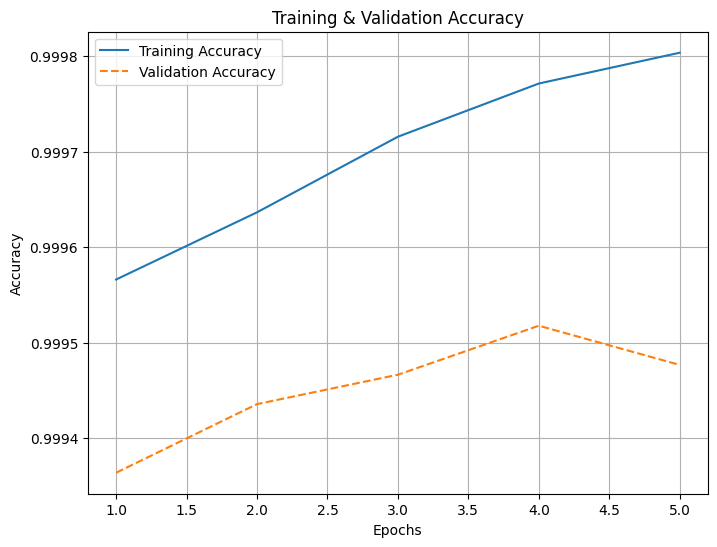

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# 測試

In [51]:
# def evaluate(model, iterator, criterion):
#     model.eval()
#     epoch_loss = 0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for texts, labels in iterator:
#             texts, labels = texts.to(device), labels.to(device)
#             predictions = model(texts).squeeze(1)
#             loss = criterion(predictions, labels)
#             epoch_loss += loss.item()

#             rounded_preds = torch.round(torch.sigmoid(predictions))  # translate logits to 0 or 1
#             correct += (rounded_preds == labels).sum().item()
#             total += labels.size(0)

#     return epoch_loss / len(iterator), correct / total

# test_loss, test_acc = evaluate(model, test_loader, criterion)
# print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%')

In [52]:
def evaluate_model(model, test_loader):
    model.eval()
    test_acc = 0
    epoch_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(DEVICE), labels.to(DEVICE)
            outputs = model(texts).squeeze()
            test_acc += ((outputs > 0.5) == labels).sum().item()
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

    test_loss = epoch_loss / len(test_loader)
    test_acc /= len(test_loader.dataset)

    return test_loss, test_acc

In [53]:
test_loss, test_acc = evaluate_model(model, test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0019, Test Accuracy: 0.9994
